# Statistical Debugging

In this chapter, we introduce _statistical debugging_ – the idea that specific events during execution could be _statistically correlated_ with failures. We start with coverage of individual lines and then proceed towards further execution features.

In [1]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.StatisticalDebugger import <identifier>
```

and then make use of the following features.


This chapter introduces classes and techniques for _statistical debugging_ – that is, correlating specific events, such as lines covered, with passing and failing outcomes.

To make use of the code in this chapter, use one of the provided `StatisticalDebugger` subclasses such as `TarantulaDebugger` or `OchiaiDebugger` instantiated with a `Collector` such as `CoverageCollector` denoting the type of events you want to correlate outcomes with. Here's a typical example:

```python
>>> debugger = TarantulaDebugger(CoverageCollector)
>>> with debugger.collect_pass():
>>>     remove_html_markup("abc")
>>> with debugger.collect_pass():
>>>     remove_html_markup('<b>abc</b>')
>>> with debugger.collect_fail():
>>>     remove_html_markup('"abc"')
```
You can then print out the observed events – in this case, line numbers – in a table, showing in which runs they occurred (`X`), and with colors highlighting the suspiciousness of the event. A "red" event means that the event predominantly occurs in failing runs.

```python
>>> debugger.event_table(args=True, color=True)
```
| `remove_html_markup` | `s='abc'` | `s='<b>abc</b>'` | `s='"abc"'` | 
| -- | ---- | ---- | ---- | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 1</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 2</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 3</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 4</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 6</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 7</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)"> 8</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 9</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">10</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">11</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(0.0, 100.0%, 80%)">12</samp> |    - |    - |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">13</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">14</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">16</samp> |    X |    X |    X | 

If you collected coverage with `CoverageCollector`, you can also visualize the code with similar colors, highlighting suspicious lines:

```python
>>> debugger.list_with_spectrum()
```
<pre style="background-color:hsl(60.0, 100.0%, 80%)">   1 def remove_html_markup(s):</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">   2     tag = False</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">   3     quote = False</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">   4     out = &quot;&quot;</pre>
<pre>   5 &nbsp;</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">   6     for c in s:</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">   7         if c == &#x27;&lt;&#x27; and not quote:</pre>
<pre style="background-color:hsl(120.0, 50.0%, 80%)">   8             tag = True</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">   9         elif c == &#x27;&gt;&#x27; and not quote:</pre>
<pre style="background-color:hsl(120.0, 50.0%, 80%)">  10             tag = False</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">  11         elif c == &#x27;&quot;&#x27; or c == &quot;&#x27;&quot; and tag:</pre>
<pre style="background-color:hsl(0.0, 100.0%, 80%)">  12             quote = not quote</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">  13         elif not tag:</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">  14             out = out + c</pre>
<pre>  15 &nbsp;</pre>
<pre style="background-color:hsl(60.0, 100.0%, 80%)">  16     return out</pre>

The method `rank_by_suspiciousness()` returns a ranked list of events, starting with the most suspicious. This is useful for automated techniques that need potential defect locations.

```python
>>> debugger.rank_by_suspiciousness()
[12, 1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16, 8, 10]
```
Here are all classes defined in this chapter:


![](PICS/StatisticalDebugger-synopsis-1.svg)


![](PICS/StatisticalDebugger-synopsis-2.svg)



![](StatisticalDebugger-synopsis-1.svg)

![x](PICS/StatisticalDebugger-synopsis-2.svg)

## Introduction

The idea behind _statistical debugging_ is fairly simple. We have a program that sometimes passes and sometimes fails. This outcome can be _correlated_ with events that precede it – properties of the input, properties of the execution, properties of the program state. If we, for instance, can find that "the program always fails when Line 123 is executed, and it always passes when Line 123 is _not_ executed", then we have a strong correlation between Line 123 being executed and failure.

Such _correlation_ does not necessarily mean _causation_. For this, we would have to prove that executing Line 123 _always_ leads to failure, and that _not_ executing it does not lead to (this) failure. Also, a correlation (or even a causation) does not mean that Line 123 contains the defect – for this, we would have to show that it actually is an error. Still, correlations make excellent hints as it comes to search for failure causes – in all generality, if you let your search be guided by _events that correlate with failures_, you are more likely to find _important hints on how the failure comes to be_.

## Collecting Events

How can we determine events that correlate with failure? We start with a general mechanism to actually _collect_ events during execution. The abstract `Collector` class provides

* a `collect()` method made for collecting events, called from the `traceit()` tracer; and
* an `events()` method made for retrieving these events.

Both of these are _abstract_ and will be defined further in subclasses.

In [2]:
from Tracer import Tracer

In [3]:
class Collector(Tracer):
    """A class to record events during execution."""

    def collect(self, frame, event, arg):
        """Collecting function. To be overridden in subclasses."""
        pass

    def events(self):
        """Return a collection of events. To be overridden in subclasses."""
        return set()

    def traceit(self, frame, event, arg):
        self.collect(frame, event, arg)

A `Collector` class is used like `Tracer`, using a `with` statement. Let us apply it on the buggy variant of `remove_html_markup()` from the [Introduction to Debugging](Intro_Debugging.ipynb):

In [4]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [5]:
with Collector() as c:
    out = remove_html_markup('"abc"')
out

'abc'

There's not much we can do with our collector, as the `collect()` and `events()` methods are yet empty. However, we can introduce an `id()` method which returns a string identifying the collector. This string is defined from the _first function call_ encountered.

In [6]:
from types import FunctionType

In [7]:
class Collector(Collector):
    def __init__(self):
        self._function = None
        self._args = None

    def traceit(self, frame, event, arg):
        if self._function is None and event == 'call':
            # Save function
            self._function = FunctionType(frame.f_code,
                                          globals=globals(),
                                          name=frame.f_code.co_name)
            locals = frame.f_locals
            self._args = ", ".join([f"{var}={repr(locals[var])}" for var in locals])

        self.collect(frame, event, arg)

    def id(self):
        """Return an identifier for the collector, created from the first call"""
        return f"{self._function.__name__}({self._args})"

    def function(self):
        """Return the function from the first call, as a function object"""
        return self._function

    def args(self):
        """Return the list of arguments from the first call, as a string"""
        return self._args

    def __repr__(self):
        # We use the ID as default representation when printed
        return self.id()

In [8]:
with Collector() as c:
    remove_html_markup('abc')
c.function(), c.id()

(<function __main__.remove_html_markup(s)>, "remove_html_markup(s='abc')")

## Collecting Coverage

So far, our `Collector` class does not collect any events. Let us extend it such that it collects _coverage_ information – that is, the set of lines executed. To this end, we introduce a `CoverageCollector` subclass which saves the coverage in a set:

In [9]:
class CoverageCollector(Collector):
    """A class to record covered lines during execution."""

    def __init__(self):
        super().__init__()
        self.coverage = set()

    def collect(self, frame, event, arg):
        self.coverage.add(frame.f_lineno)

We also override `events()` such that it returns the set of covered lines.

In [10]:
class CoverageCollector(CoverageCollector):
    def events(self):
        """Return a set of predicates holding for the execution"""
        return self.coverage

Here is how we can use `CoverageCollector` to determine the lines executed during a run of `remove_html_markup()`:

In [11]:
with CoverageCollector() as c:
    remove_html_markup('abc')
c.events()

{1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16}

Sets of line numbers alone are not too revealing. They provide more insights if we actually list the code, highlighting these numbers:

In [12]:
import inspect

In [13]:
from bookutils import getsourcelines    # like inspect.getsourcelines(), but in color

In [14]:
def list_with_coverage(function, coverage):
    source_lines, starting_line_number = \
       getsourcelines(function)

    line_number = starting_line_number
    for line in source_lines:
        marker = '*' if line_number in coverage else ' '
        print(f"{line_number:4} {marker} {line}", end='')
        line_number += 1

In [15]:
list_with_coverage(remove_html_markup, c.coverage)

   1 * def remove_html_markup(s):
   2 *     tag = False
   3 *     quote = False
   4 *     out = ""
   5   
   6 *     for c in s:
   7 *         if c == '<' and not quote:
   8               tag = True
   9 *         elif c == '>' and not quote:
  10               tag = False
  11 *         elif c == '"' or c == "'" and tag:
  12               quote = not quote
  13 *         elif not tag:
  14 *             out = out + c
  15   
  16 *     return out


Remember that the input `s` was `"abc"`? In this listing, we can see which lines were covered and which lines were not. From the listing already, we can see that `s` has neither tags nor quotes.

Such coverage computation plays a big role in _testing_, as one wants tests to cover as many different aspects of program execution (and notably code) as possible. But also during debugging, code coverage is essential: If some code was not even executed in the failing run, then any change to it will have no effect.

In [16]:
from bookutils import quiz

In [17]:
quiz("Let the input be <code>&quot;&lt;b&gt;Don't do this!&lt;/b&gt;&quot;</code>. "
     "Which of these lines are executed? Use the code to find out!",
     [
         "<code>tag = True</code>",
         "<code>tag = False</code>",
         "<code>quote = not quote</code>",
         "<code>out = out + c</code>"
     ], [ord(c) - ord('a') - 1 for c in 'cdf'])

To find the solution, try this out yourself:

In [18]:
with CoverageCollector() as c:
    remove_html_markup("<b>Don't do this!</b>")
# list_with_coverage(remove_html_markup, c.coverage)

## Computing Differences

Let us get back to the idea that we want to _correlate_ events with passing and failing outcomes. For this, we need to examine events in both _passing_ and _failing_ runs, and determine their _differences_ – since it is these differences we want to associate with their respective outcome.

### A Base Class for Statistical Debugging

The `StatisticalDebugger` base class takes a collector class (such as `CoverageCollector`). Its `collect()` method creates a new collector of that very class, which will be maintained by the debugger. As argument, `collect()` takes a string characterizing the outcome (such as `'PASS'` or `'FAIL'`). This is how one would use it:

```python
debugger = StatisticalDebugger(CoverageCollector)
with debugger.collect('PASS'):
    some_passing_run()
with debugger.collect('PASS'):
    another_passing_run()
with debugger.collect('FAIL'):
    some_failing_run()
```

Let us implement `StatisticalDebugger`. The base class gets a collector class as argument:

In [19]:
class StatisticalDebugger():
    """A class to collect events for multiple outcomes."""

    def __init__(self, collector_class):
        self.collector_class = collector_class
        self.collectors = {}

The `collect()` method creates (and stores) a collector for the given outcome, using the given outcome to characterize the run. Any additional arguments are passed to the collector.

In [20]:
class StatisticalDebugger(StatisticalDebugger):
    def collect(self, outcome, *args):
        """Return a collector for the given outcome. 
        Additional args are passed to the collector."""
        collector = self.collector_class(*args)
        if outcome not in self.collectors:
            self.collectors[outcome] = []
        self.collectors[outcome].append(collector)
        return collector

The `all_events()` method produces a union of all events observed. If an outcome is given, it produces a union of all events with that outcome:

In [21]:
class StatisticalDebugger(StatisticalDebugger):
    def all_events(self, outcome=None):
        """Return a set of all events observed."""
        all_events = set()
        if outcome:
            for collector in self.collectors[outcome]:
                all_events.update(collector.events())
        else:
            for outcome in self.collectors:
                for collector in self.collectors[outcome]:
                    all_events.update(collector.events())
        return all_events

Here's a simple example of `StatisticalDebugger` in action:

In [22]:
s = StatisticalDebugger(CoverageCollector)
with s.collect('PASS'):
    remove_html_markup("abc")
with s.collect('PASS'):
    remove_html_markup('<b>abc</b>')
with s.collect('FAIL'):
    remove_html_markup('"abc"')

The method `all_events()` returns all events collected:

In [23]:
s.all_events()

{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16}

If given an outcome as argument, we obtain all events with the given outcome.

In [24]:
s.all_events('FAIL')

{1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 16}

The attribute `collectors` maps outcomes to lists of collectors:

In [25]:
s.collectors

{'PASS': [remove_html_markup(s='abc'), remove_html_markup(s='<b>abc</b>')],
 'FAIL': [remove_html_markup(s='"abc"')]}

Here's the collector of the one (and first) passing run:

In [26]:
s.collectors['PASS'][0].id()

"remove_html_markup(s='abc')"

In [27]:
s.collectors['PASS'][0].events()

{1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16}

To better highlight the differences between the collected events, we introduce a method `event_table()` that prints out whether an event took place in a run.

### Excursion: Printing an Event Table

In [28]:
from IPython.display import display, Markdown, HTML

In [29]:
import html

In [30]:
class StatisticalDebugger(StatisticalDebugger):
    def function(self):
        """Return the function from the events observed, or None if ambiguous"""
        function = None
        for outcome in self.collectors:
            for collector in self.collectors[outcome]:
                if function is None:
                    function = collector.function()
                elif function.__name__ != collector.function().__name__:
                    return None  # ambiguous

        return function

    def color(self, event):
        """Return a color for the given event, or None. To be overloaded in subclasses."""
        return None

    def event_table_text(self, args=False, color=False):
        """Print out a table of events observed.
           If args is set, use arguments as headers.
           If color is set, use colors."""
        sep = ' | '

        all_events = self.all_events()
        longest_event = max(len(f"{event}") for event in all_events)

        out = ""

        # Header
        if args:
            out += '| ' + '`' + self.function().__name__ + '`' + sep
            for name in self.collectors:
                for collector in self.collectors[name]:
                    out += '`' + collector.args() + '`' + sep
            out += '\n'
        else:
            out += '| ' + ' ' * longest_event + sep
            for name in self.collectors:
                for i in range(len(self.collectors[name])):
                    out += name + sep
            out += '\n'

        out += '| ' + '-' * longest_event + sep
        for name in self.collectors:
            for i in range(len(self.collectors[name])):
                out += '-' * len(name) + sep
        out += '\n'

        # Data
        for event in all_events:
            event_name = str(event).rjust(longest_event)  # could also use repr(event)

            if color:
                color_name = self.color(event)
                if color_name:
                    event_name = \
                        f'<samp style="background-color: {color_name}">{html.escape(event_name)}</samp>'

            out += f"| {event_name}" + sep
            for name in self.collectors:
                for collector in self.collectors[name]:
                    out += ' ' * (len(name) - 1)
                    if event in collector.events():
                        out += "X"
                    else:
                        out += "-"
                    out += sep
            out += '\n'

        return out

    def event_table(self, **_args):
        """Print out event table in Markdown format."""
        return Markdown(self.event_table_text(**_args))

    def __repr__(self):
        return self._event_table_text()

### End of Excursion

In [31]:
s = StatisticalDebugger(CoverageCollector)
with s.collect('PASS'):
    remove_html_markup("abc")
with s.collect('PASS'):
    remove_html_markup('<b>abc</b>')
with s.collect('FAIL'):
    remove_html_markup('"abc"')
s.event_table(args=True)

| `remove_html_markup` | `s='abc'` | `s='<b>abc</b>'` | `s='"abc"'` | 
| -- | ---- | ---- | ---- | 
|  1 |    X |    X |    X | 
|  2 |    X |    X |    X | 
|  3 |    X |    X |    X | 
|  4 |    X |    X |    X | 
|  6 |    X |    X |    X | 
|  7 |    X |    X |    X | 
|  8 |    - |    X |    - | 
|  9 |    X |    X |    X | 
| 10 |    - |    X |    - | 
| 11 |    X |    X |    X | 
| 12 |    - |    - |    X | 
| 13 |    X |    X |    X | 
| 14 |    X |    X |    X | 
| 16 |    X |    X |    X | 


In [32]:
quiz("How many lines are executed in the failing run only?",
    ["One", "Two", "Three"], int(chr(50)))

These lines only executed in the failing run would be a correlation to look for.

### Collecting Passing and Failing Runs

While our `StatisticalDebugger` class allows arbitrary outcomes, we are typically only interested in two outcomes, namely _passing_ vs. _failing_ runs. We therefore introduce a specialized `DifferenceDebugger` class that provides customized methods to collect and access passing and failing runs.

In [33]:
class DifferenceDebugger(StatisticalDebugger):
    """A class to collect events for passing and failing outcomes."""

    PASS = 'PASS'
    FAIL = 'FAIL'

    def collect_pass(self, *args):
        """Return a collector for passing runs."""
        return self.collect(self.PASS, *args)

    def collect_fail(self, *args):
        """Return a collector for failing runs."""
        return self.collect(self.FAIL, *args)

    def pass_collectors(self):
        return self.collectors[self.PASS]

    def fail_collectors(self):
        return self.collectors[self.FAIL]

Here's how to use `DifferenceDebugger`:

In [34]:
def test_debugger_html(debugger):
    with debugger.collect_pass():
        remove_html_markup('abc')
    with debugger.collect_pass():
        remove_html_markup('<b>abc</b>')
    with debugger.collect_fail():
        remove_html_markup('"abc"')
    return debugger

In [35]:
debugger = test_debugger_html(DifferenceDebugger(CoverageCollector))

Since events come back as _sets_, we can compute _unions_ and _differences_ between these sets. For instance, we can compute which lines were executed in _any_ of the passing runs:

In [36]:
pass_1_events = debugger.pass_collectors()[0].events()

In [37]:
pass_2_events = debugger.pass_collectors()[1].events()

In [38]:
in_any_pass = pass_1_events | pass_2_events
in_any_pass

{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 16}

Likewise, we can determine which lines were _only_ executed in the failing run:

In [39]:
fail_events = debugger.fail_collectors()[0].events()

In [40]:
only_in_fail = fail_events - in_any_pass
only_in_fail

{12}

And we see that the "failing" run is characterized by processing quotes:

In [41]:
list_with_coverage(remove_html_markup, only_in_fail)

   1   def remove_html_markup(s):
   2       tag = False
   3       quote = False
   4       out = ""
   5   
   6       for c in s:
   7           if c == '<' and not quote:
   8               tag = True
   9           elif c == '>' and not quote:
  10               tag = False
  11           elif c == '"' or c == "'" and tag:
  12 *             quote = not quote
  13           elif not tag:
  14               out = out + c
  15   
  16       return out


Let us add a few helper methods that return computations such as the above. 

In [42]:
class DifferenceDebugger(DifferenceDebugger):
    def all_fail_events(self):
        """Return all events observed in failing runs."""
        return self.all_events(self.FAIL)

    def all_pass_events(self):
        """Return all events observed in passing runs."""
        return self.all_events(self.PASS)

We can now introduce helper methods that show the events occurring only in passing and failing runs, respectively:

In [43]:
class DifferenceDebugger(DifferenceDebugger):
    def only_fail_events(self):
        """Return all events observed only in failing runs."""
        return self.all_fail_events() - self.all_pass_events()

    def only_pass_events(self):
        """Return all events observed only in passing runs."""
        return self.all_pass_events() - self.all_fail_events()

In [44]:
debugger = test_debugger_html(DifferenceDebugger(CoverageCollector))

In [45]:
debugger.all_events()

{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16}

These are the lines executed only in the failing run:

In [46]:
debugger.only_fail_events()

{12}

These are the lines executed only in the passing runs:

In [47]:
debugger.only_pass_events()

{8, 10}

Again, having these lines individually is neat, but things become much more interesting if we can see the associated code lines just as well. That's what we will do in the next section.

## Visualizing Differences

To show correlations of line coverage in context, we introduce a number of _visualization_ techniques that _highlight_ code with different colors.

### Discrete Spectrum

The first idea is to use a _discrete_ spectrum of three colors:

* _red_ for code executed in failing runs only
* _green_ for code executed in passing runs only
* _yellow_ for code executed in both passing and failing runs.

Code that is not executed stays unhighlighted.

Our `DiscreteSpectrumDebugger` subclass provides a `color()` method that returns one of these three colors depending on the line number:

In [48]:
class DiscreteSpectrumDebugger(DifferenceDebugger):
    def suspiciousness(self, event):
        """Return a suspiciousness value [0, 1.0] for the given event, or None if unknown"""
        passing = self.all_pass_events()
        failing = self.all_fail_events()

        if event in passing and event in failing:
            return 0.5
        elif event in failing:
            return 1.0
        elif event in passing:
            return 0.0
        else:
            return None

    def color(self, event):
        """Return a color for the given event."""
        suspiciousness = self.suspiciousness(event)
        if suspiciousness is None:
            return None

        if suspiciousness > 0.8:
            return 'mistyrose'
        if suspiciousness >= 0.5:
            return 'lightyellow'
        
        return 'honeydew'

The `list_with_spectrum()` method takes a function and shows each of its source code lines using the given spectrum, using HTML markup:

In [49]:
class DiscreteSpectrumDebugger(DiscreteSpectrumDebugger):
    def list_with_spectrum(self, function=None, show_color_names=False):
        """Print a listing of the given function, using suspiciousness colors."""
        if function is None:
            function = self.function()
        if function is None:
            raise ValueError("Must specify function to list")

        source_lines, starting_line_number = \
           inspect.getsourcelines(function)

        line_number = starting_line_number
        out = ""
        for line in source_lines:
            line = html.escape(line)
            if line.strip() == '':
                line = '&nbsp;'

            line = str(line_number).rjust(4) + ' ' + line
            color = self.color(line_number)

            if show_color_names:
                line = f'{repr(color):20} {line}'

            if color:
                line = f'<pre style="background-color:{color}">' \
                        f'{line.rstrip()}</pre>'
            else:
                line = f'<pre>{line}</pre>'

            out += line + '\n'
            line_number += 1

        return HTML(out)

    def list_with_suspiciousness(self, function=None):
        """Print a listing of the given function, using suspiciousness values."""
        if function is None:
            function = self.function()
        if function is None:
            raise ValueError("Must specify function to list")

        source_lines, starting_line_number = \
           inspect.getsourcelines(function)

        line_number = starting_line_number
        out = ""
        for line in source_lines:
            suspiciousness = self.suspiciousness(line_number)
            line = str(line_number).rjust(4) + ' ' + str(suspiciousness).rjust(4) + line
            out += line + '\n'
            line_number += 1

        return out

    def __repr__(self):
        return self.list_with_suspiciousness()

This is how the `only_pass_events()` and `only_fail_events()` sets look like when visualized with code. The "culprit" line is well highlighted:

In [50]:
debugger = test_debugger_html(DiscreteSpectrumDebugger(CoverageCollector))

In [51]:
debugger.list_with_spectrum()

We can clearly see that the failure is correlated with the presence of quotes in the input string (which is an important hint!). But does this also show us _immediately_ where the defect to be fixed is?

In [52]:
quiz("Does the line <code>quote = not quote</code> actually contain the defect?",
    [
        "Yes, it should be fixed",
        "No, the defect is elsewhere"
    ],
     164 * 2 % 326
    )

Indeed, it is the preceding condition that is wrong. In order to fix a program, we have to find a location that

1. _causes_ the failure (i.e., it can be changed to make the failure go away); and
2. is a _defect_ (i.e., contains an error).

In our example above, the highlighted code line is a _symptom_ for the error. To some extent, it is also a _cause_, since, say, commenting it out would also resolve the given failure, at the cost of causing other failures. However, the preceding condition also is a cause, as is the presence of quotes in the input.

Only one of these also is a _defect_, though, and that is the preceding condition. Hence, while correlations can provide important hints, they do not necessarily locate defects.

For those of us who may not have color HTML output ready, we introduce a variant that simply lists suspiciousness values as percentages.

In [53]:
class DiscreteSpectrumDebugger(DiscreteSpectrumDebugger):
    def list_with_suspiciousness(self, function=None):
        """Print a listing of the given function, including suspiciousness values."""
        if function is None:
            function = self.function()
        if function is None:
            raise ValueError("Must specify function to list")

        source_lines, starting_line_number = \
           inspect.getsourcelines(function)

        line_number = starting_line_number
        out = ""
        for line in source_lines:
            suspiciousness = self.suspiciousness(line_number)
            if suspiciousness is not None:
                percentage = str(int(suspiciousness * 100)).rjust(3) + '%'
            else:
                percentage = ' ' * len('100%')
            line = str(line_number).rjust(4) + ' ' + percentage + ' ' + line
            out += line
            line_number += 1

        return out

    def __repr__(self):
        return self.list_with_suspiciousness()

In [54]:
debugger = test_debugger_html(DiscreteSpectrumDebugger(CoverageCollector))
debugger

   1  50% def remove_html_markup(s):
   2  50%     tag = False
   3  50%     quote = False
   4  50%     out = ""
   5      
   6  50%     for c in s:
   7  50%         if c == '<' and not quote:
   8   0%             tag = True
   9  50%         elif c == '>' and not quote:
  10   0%             tag = False
  11  50%         elif c == '"' or c == "'" and tag:
  12 100%             quote = not quote
  13  50%         elif not tag:
  14  50%             out = out + c
  15      
  16  50%     return out

### Continuous Spectrum

The criterion that an event should _only_ occur in failing runs (and not in passing runs) can be too aggressive. In particular, if we have another run that executes the "culprit" lines, but does _not_ fail, our "only in fail" criterion will no longer be helpful.

Here is an example. The input

```html
<b color="blue">text</b>
```

will trigger the "culprit" line

```python
quote = not quote
```

but actually produce an output where the tags are properly stripped:

In [55]:
remove_html_markup('<b color="blue">text</b>')

'text'

As a consequence, we no longer have lines that are being executed only in failing runs:

In [56]:
debugger = test_debugger_html(DiscreteSpectrumDebugger(CoverageCollector))
with debugger.collect_pass():
    remove_html_markup('<b link="blue"></b>')

In [57]:
debugger.only_fail_events()

set()

In our spectrum output, the effect now is that the "culprit" line is as yellow as all others.

In [58]:
debugger.list_with_spectrum()

We therefore introduce a different method for highlighting lines, based on their _relative_ occurrence with respect to all runs: If a line has been _mostly_ executed in failing runs, its color should shift towards red; if a line has been _mostly_ executed in passing runs, its color should shift towards green.

This _continuous spectrum_ has been introduced by the seminal _Tarantula_ tool \cite{Jones2002}. In Tarantula, the color _hue_ for each line is defined as follows:

$$\textit{color hue}(\textit{line}) = \textit{low color(red)} + \frac{\%\textit{passed}(\textit{line})}{\%\textit{passed}(\textit{line}) + \%\textit{failed}(\textit{line})} \times \textit{color range}$$

Here, `%passed` and `%failed` denote the percentage at which a line has been executed in passing and failing runs, respectively. A hue of 0.0 stands for red, a hue of 1.0 stands for green, and a hue of 0.5 stands for equal fractions of red and green, yielding yellow.

We can implement these measures right away as methods in a new `ContinuousSpectrumDebugger` class:

In [59]:
class ContinuousSpectrumDebugger(DiscreteSpectrumDebugger):
    def collectors_with_event(self, event, category):
        """Return all collectors in a category that observed the given event."""
        all_runs = self.collectors[category]
        collectors_with_event = set(collector for collector in all_runs 
                              if event in collector.events())
        return collectors_with_event

    def collectors_without_event(self, event, category):
        """Return all collectors in a category that did not observe the given event."""
        all_runs = self.collectors[category]
        collectors_without_event = set(collector for collector in all_runs 
                              if event not in collector.events())
        return collectors_without_event

    def event_fraction(self, event, category):
        all_collectors = self.collectors[category]
        collectors_with_event = self.collectors_with_event(event, category)
        fraction = len(collectors_with_event) / len(all_collectors)
        # print(f"%{category}({event}) = {fraction}")
        return fraction

    def passed_fraction(self, line_number):
        return self.event_fraction(line_number, self.PASS)

    def failed_fraction(self, line_number):
        return self.event_fraction(line_number, self.FAIL)

    def hue(self, line_number):
        """Return a color hue from 0.0 (red) to 1.0 (green)."""
        passed = self.passed_fraction(line_number)
        failed = self.failed_fraction(line_number)
        if passed + failed > 0:
            return passed / (passed + failed)
        else:
            return None

The hue for lines executed only in failing runs is (deep) red, as expected:

In [60]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))

In [61]:
for line in debugger.only_fail_events():
    print(line, debugger.hue(line))

12 0.0


Likewise, the hue for lines executed in passing runs is (deep) green:

In [62]:
for line in debugger.only_pass_events():
    print(line, debugger.hue(line))

8 1.0
10 1.0


The Tarantula tool not only sets the hue for a line, but also uses _brightness_ as measure for support – that is, how often was the line executed at all. The brighter a line, the stronger the correlation with a passing or failing outcome.

The brightness is defined as follows:

$$\textit{brightness}(line) = \max(\%\textit{passed}(\textit{line}), \%\textit{failed}(\textit{line}))$$

and it is easily implemented, too:

In [63]:
class ContinuousSpectrumDebugger(ContinuousSpectrumDebugger):
    def brightness(self, line):
        return max(self.passed_fraction(line), self.failed_fraction(line))

Our single "only in fail" line has a brightness of 1.0 (the maximum).

In [64]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))
for line in debugger.only_fail_events():
    print(line, debugger.brightness(line))

12 1.0


With this, we can now define a color for each line. To this end, we override the (previously discrete) `color()` method such that it returns a color specification giving hue and brightness. We use the HTML format `hsl(hue, saturation, lightness)` where the hue is given as a value between 0 and 360 (0 is red, 120 is green) and saturation and lightness are provided as percentages.

In [65]:
class ContinuousSpectrumDebugger(ContinuousSpectrumDebugger):
    def color(self, line):
        hue = debugger.hue(line)
        if hue is None:
            return None
        saturation = debugger.brightness(line)

        # HSL color values are specified with: 
        # hsl(hue, saturation, lightness).
        return f"hsl({hue * 120}, {saturation * 100}%, 80%)"

In [66]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))

Lines executed only in failing runs are still shown in red:

In [67]:
for line in debugger.only_fail_events():
    print(line, debugger.color(line))

12 hsl(0.0, 100.0%, 80%)


... whereas lines executed only in passing runs are still shown in green:

In [68]:
for line in debugger.only_pass_events():
    print(line, debugger.color(line))

8 hsl(120.0, 50.0%, 80%)
10 hsl(120.0, 50.0%, 80%)


In [69]:
debugger.list_with_spectrum()

What happens with our `quote = not quote` "culprit" line if it is executed in passing runs, too?

In [70]:
with debugger.collect_pass():
    out = remove_html_markup('<b link="blue"></b>')

In [71]:
quiz('In which color will the <code>quote = not quote</code> "culprit" line be shown after executing the above code?',
    [
        '<span style="background-color: hsl(120.0, 50.0%, 80%)">Green</span>',
        '<span style="background-color: hsl(60.0, 100.0%, 80%)">Yellow</span>',
        '<span style="background-color: hsl(30.0, 100.0%, 80%)">Orange</span>',
        '<span style="background-color: hsl(0.0, 100.0%, 80%)">Red</span>'
    ],
     999 / 333
    )

We see that it still is shown with an orange-red tint.

In [72]:
debugger.list_with_spectrum()

Here's another example, coming right from the Tarantula paper. The `middle()` function takes three numbers `x`, `y`, and `z`, and returns the one that is neither the minimum nor the maximum of the three:

In [73]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In [74]:
middle(1, 2, 3)

2

Unfortunately, `middle()` can fail:

In [75]:
middle(2, 1, 3)

1

Let is see whether we can find the bug with a few additional test cases:

In [76]:
def test_debugger_middle(debugger):
    with debugger.collect_pass():
        middle(3, 3, 5)
    with debugger.collect_pass():
        middle(1, 2, 3)
    with debugger.collect_pass():
        middle(3, 2, 1)
    with debugger.collect_pass():
        middle(5, 5, 5)
    with debugger.collect_pass():
        middle(5, 3, 4)
    with debugger.collect_fail():
        middle(2, 1, 3)
    return debugger

Note that in order to collect data from multiple function invocations, you need to have a separate `with` clause for every invocation. The following will _not_ work correctly:

```python
    with debugger.collect_pass():
        middle(3, 3, 5)
        middle(1, 2, 3)
        ...
```

In [77]:
debugger = test_debugger_middle(ContinuousSpectrumDebugger(CoverageCollector))

In [78]:
debugger.event_table(args=True)

| `middle` | `z=5, y=3, x=3` | `z=3, y=2, x=1` | `z=1, y=2, x=3` | `z=5, y=5, x=5` | `z=4, y=3, x=5` | `z=3, y=1, x=2` | 
| -- | ---- | ---- | ---- | ---- | ---- | ---- | 
|  1 |    X |    X |    X |    X |    X |    X | 
|  2 |    X |    X |    X |    X |    X |    X | 
|  3 |    X |    X |    - |    - |    X |    X | 
|  4 |    - |    X |    - |    - |    - |    - | 
|  5 |    X |    - |    - |    - |    X |    X | 
|  6 |    X |    - |    - |    - |    - |    X | 
|  8 |    - |    - |    X |    X |    - |    - | 
|  9 |    - |    - |    X |    - |    - |    - | 
| 10 |    - |    - |    - |    X |    - |    - | 
| 12 |    - |    - |    - |    X |    X |    - | 


Here us the visualization. We see that the `return y` line is the culprit here – and actually also the one to be fixed.

In [79]:
debugger.list_with_spectrum()

In [80]:
quiz("Which of the above lines should be fixed?",
    [
        '<span style="background-color: hsl(45.0, 100%, 80%)">Line 3: <code>elif x &lt; y</code></span>',
        '<span style="background-color: hsl(34.28571428571429, 100.0%, 80%)">Line 5: <code>elif x &lt; z</code></span>',
        '<span style="background-color: hsl(20.000000000000004, 100.0%, 80%)">Line 6: <code>return y</code></span>',
        '<span style="background-color: hsl(120.0, 20.0%, 80%)">Line 9: <code>return y</code></span>',
    ],
     len(" middle \n".strip()[:3])
    )

Indeed, in the `middle()` example, the "reddest" line is also the one to be fixed.  Here is the fixed version:

In [81]:
def middle_fixed(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In [82]:
middle_fixed(2, 1, 3)

2

## Ranking Lines by Suspiciousness

In a large program, there can be several locations (and events) that could be flagged as suspicious. It suffices that some large code block of say, 1,000 lines, is mostly executed in failing runs, and then all of this code block will be visualized in some shade of red. 

To further highlight the "most suspicious" events, one idea is to use a _ranking_ – that is, coming up with a list of events where those events most correlated with failures would be shown at the top. The programmer would then examine these events one by one and proceed down the list. We will show how this works for two "correlation" metrics – first the _Tarantula_ metric, as introduced above, and then the _Ochiai_ metric, which has shown to be one of the best "ranking" metrics.

We introduce a base class `RankingDebugger` with an abstract method `suspiciousness()` to be overloaded in subclasses. The method `rank_by_suspiciousness()` returns a list of all events observed, sorted by suspiciousness, highest first.

In [83]:
class RankingDebugger(DifferenceDebugger):
    def suspiciousness(self, event):
        """Return the suspiciousness (>=0) of an event. 0 stands for not suspicious."""
        return 0

    def rank_by_suspiciousness(self):
        """Return a list of events, sorted by suspiciousness, highest first."""
        events = list(self.all_events())
        events.sort(key=self.suspiciousness, reverse=True)
        return events

    def __repr__(self):
        return repr(self.rank_by_suspiciousness())

### The Tarantula Metric

We can use the Tarantula metric to sort lines according to their suspiciousness. The "redder" a line (a hue of 0.0), the more suspicious it is. We can simply define

$$
\textit{suspiciousness}_\textit{tarantula}(\textit{event}) = 1 - \textit{color hue}(\textit{event})
$$

where $\textit{color hue}$ is as defined above.

We introduce the `TarantulaDebugger` class, inheriting visualization capabilities from the `ContinuousSpectrumDebugger` class as well as the suspiciousness features from the `RankingDebugger` class.

In [84]:
class TarantulaDebugger(ContinuousSpectrumDebugger, RankingDebugger):
    def suspiciousness(self, event):
        hue = self.hue(event)
        if hue is None:
            return None
        return 1 - hue

Let us list `remove_html_markup()` with highlighted lines again:

In [85]:
debugger = test_debugger_html(TarantulaDebugger(CoverageCollector))

In [86]:
debugger.list_with_spectrum()

Here's our ranking of lines, from most suspicious to least suspicious:

In [87]:
debugger.rank_by_suspiciousness()

[12, 1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16, 8, 10]

In [88]:
debugger.suspiciousness(2)

0.5

We see that the first line in the list is indeed the most suspicious; the two "green" lines come at the very end.

For the `middle()` function, we also obtain a ranking from "reddest" to "greenest".

In [89]:
debugger = test_debugger_middle(TarantulaDebugger(CoverageCollector))

In [90]:
debugger.list_with_spectrum()

In [91]:
debugger.rank_by_suspiciousness()

[6, 5, 3, 1, 2, 4, 8, 9, 10, 12]

In [92]:
debugger.suspiciousness(5)

0.7142857142857142

### The Ochiai Metric

The _Ochiai_ Metric \cite{Ochiai1957} first introduced in the biology domain \cite{daSilvaMeyer2004} and later applied for fault localization by Abreu et al. \cite{Abreu2009}, is defined as follows:

$$
\textit{suspiciousness}_\textit{ochiai} = 
\frac
{\textit{failed}(\textit{event})}
{\sqrt{
\bigl(\textit{failed}(\textit{event}) + \textit{not-in-failed}(\textit{event})\bigr)
\times
\bigl(\textit{failed}(\textit{event}) + \textit{passed}(\textit{event})\bigr)
}}
$$

where

* $\textit{failed}(\textit{event})$ is the number of times the event occurred in _failing_ runs
* $\textit{not-in-failed}(\textit{event})$ is the number of times the event did _not_ occur in failing runs
* $\textit{passed}(\textit{event})$ is the number of times the event occurred in _passing_ runs.

We can easily implement this formula:

In [93]:
import math

In [94]:
class OchiaiDebugger(ContinuousSpectrumDebugger, RankingDebugger):
    def suspiciousness(self, event):
        failed = len(self.collectors_with_event(event, self.FAIL))
        not_in_failed = len(self.collectors_without_event(event, self.FAIL))
        passed = len(self.collectors_with_event(event, self.PASS))

        try:
            return failed / math.sqrt((failed + not_in_failed) * (failed + passed))
        except ZeroDivisionError:
            return None

    def hue(self, event):
        suspiciousness = self.suspiciousness(event)
        if suspiciousness is None:
            return None
        return 1 - suspiciousness

Applied on the `remove_html_markup()` function, the individual suspiciousness scores differ from Tarantula. However, we obtain a very similar visualization, and the same ranking.

In [95]:
debugger = test_debugger_html(OchiaiDebugger(CoverageCollector))

In [96]:
debugger.list_with_spectrum()

In [97]:
debugger.rank_by_suspiciousness()

[12, 1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16, 8, 10]

In [98]:
debugger.suspiciousness(2)

0.5773502691896258

The same observations also apply for the `middle()` function.

In [99]:
debugger = test_debugger_middle(OchiaiDebugger(CoverageCollector))

In [100]:
debugger.list_with_spectrum(middle)

In [101]:
debugger.rank_by_suspiciousness()

[6, 5, 3, 1, 2, 4, 8, 9, 10, 12]

In [102]:
debugger.suspiciousness(5)

0.5773502691896258

### How Useful is Ranking?

So, which metric is better? The standard method to evaluate such rankings is to determine a _ground truth_ – that is, the set of locations that eventually are fixed – and to check at which point in the ranking any such location occurs – the earlier, the better. In our `remove_html_markup()` and `middle()` examples, both the Tarantula and the Ochiai metric perform flawlessly, as the "culprit" line is always ranked at the top. However, this need not always be the case; the exact performance depends on the nature of the code and the observed runs. (Also, the question of whether there always is exactly one possible location where the program can be fixed is open for discussion.)

You will be surprised that over time, _several dozen_ metrics have been proposed \cite{Wong2016}, each performing somewhat better or somewhat worse depending on which benchmark they were applied on. The two metrics discussed above each have their merits – the Tarantula metric was among the first such metrics, and the Ochiai metric is generally shown to be among the most effective ones \cite{Abreu2009}.

While rankings can be easily _evaluated_, it is not necessarily clear whether and how much they serve programmers. As stated above, the assumption of rankings is that developers examine one potentially defective statement after another until they find the actually defective one. However, in a series of human studies with developers, Parnin and Orso \cite{Parnin2011} found that this assumption may not hold:

> It is unclear whether developers can actually determine the faulty nature of a statement by simply looking at it, without any additional information (e.g., the state of the program when the statement was executed or the statements that were executed before or after that one).

In their study, they found that rankings could help completing a task faster, but this effect was limited to experienced developers and simpler code. Artificially changing the rank of faulty statements had little to no effect, implying that developers would not strictly follow the ranked list of statements, but rather search through the code to understand it. At this point, a _visualization_ as in the Tarantula tool can be helpful to programmers as it _guides_ the search, but a _ranking_ that _defines_ where to search may be less useful.

Having said that, ranking has its merits – notably as it comes to informing _automated_ debugging techniques. In the [chapter on program repair](Repair.ipynb), we will see how ranked lists of potentially faulty statements tell automated repair techniques where to try to repair the program first. And once such a repair is successful, we have a very strong indication on where and how the program could be fixed!

## Other Events besides Coverage

We close this chapter with two directions for further thought. If you wondered why in the above code, we were mostly talking about `events` rather than lines covered, that is because our framework allows for tracking arbitrary events, not just coverage. In fact, any data item a collector can extract from the execution can be used for correlation analysis. (It may not be so easily visualized, though.)

Here's an example. We define a `ValueCollector` class that collects pairs of (local) variables and their values during execution. Its `events()` method then returns the set of all these pairs.

In [103]:
class ValueCollector(Collector):
    """"A class to collect local variables and their values."""

    def __init__(self):
        super().__init__()
        self.vars = set()

    def collect(self, frame, event, arg):
        local_vars = frame.f_locals
        for var in local_vars:
            value = local_vars[var]
            self.vars.add(f"{var} = {repr(value)}")

    def events(self):
        """A set of (variable, value) pairs observed"""
        return self.vars

If we apply this collector on our set of HTML test cases, these are all the events that we obtain – essentially all variables and all values ever seen:

In [104]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(ValueCollector))
for event in debugger.all_events():
    print(event)

c = 'a'
s = 'abc'
c = '/'
c = 'b'
out = 'abc'
out = 'ab'
c = 'c'
c = '<'
tag = True
quote = True
out = 'a'
s = '"abc"'
out = ''
c = '"'
c = '>'
tag = False
s = '<b>abc</b>'
quote = False


However, some of these events only occur in the failing run:

In [105]:
for event in debugger.only_fail_events():
    print(event)

s = '"abc"'
c = '"'
quote = True


Some of these differences are spurious – the string `"abc"` (with quotes) only occurs in the failing run – but others, such as `quote` being True and `c` containing a single quote are actually relevant for explaining when the failure comes to be.

We can even visualize the suspiciousness of the individual events, setting the (so far undiscussed) `color` flag for producing an event table:

In [106]:
debugger.event_table(color=True, args=True)

| `remove_html_markup` | `s='abc'` | `s='<b>abc</b>'` | `s='"abc"'` | 
| ---------------- | ---- | ---- | ---- | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">         c = &#x27;a&#x27;</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">       s = &#x27;abc&#x27;</samp> |    X |    - |    - | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">         c = &#x27;/&#x27;</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">         c = &#x27;b&#x27;</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">     out = &#x27;abc&#x27;</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">      out = &#x27;ab&#x27;</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">         c = &#x27;c&#x27;</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">         c = &#x27;&lt;&#x27;</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">      tag = True</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(0.0, 100.0%, 80%)">    quote = True</samp> |    - |    - |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">       out = &#x27;a&#x27;</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(0.0, 100.0%, 80%)">     s = &#x27;&quot;abc&quot;&#x27;</samp> |    - |    - |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">        out = &#x27;&#x27;</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(0.0, 100.0%, 80%)">         c = &#x27;&quot;&#x27;</samp> |    - |    - |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">         c = &#x27;&gt;&#x27;</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">     tag = False</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">s = &#x27;&lt;b&gt;abc&lt;/b&gt;&#x27;</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">   quote = False</samp> |    X |    X |    X | 


There are many ways one can continue from here.

* Rather than checking for concrete values, one could check for more _abstract properties_, for instance – what is the sign of the value? What is the length of the string? 
* One could check for specifics of the _control flow_ – is the loop taken? How many times?
* One could check for specifics of the _information flow_ – which values flow from one variable to another?

There are lots of properties that all could be related to failures – and if we happen to check for the right one, we may obtain a much crisper definition of what causes the failure. We will come up with more ideas on properties to check as it comes to [mining specifications](SpecificationMining,ipynb).

## Training Classifiers

The metrics we have discussed so far are pretty _generic_ – that is, they are fixed no matter how the actual event space is structured. The field of _machine learning_ has come up with techniques that learn _classifiers_ from a given set of data – classifiers that are trained from labeled data and then can predict labels for new data sets. In our case, the labels are test outcomes (PASS and FAIL), whereas the data would be features of the events observed.

A classifier by itself is not immediately useful for debugging (although it could predict whether future inputs will fail or not). Some classifiers, however, have great _diagnostic_ quality; that is, they can _explain_ how their classification comes to be. [Decision trees](https://scikit-learn.org/stable/modules/tree.html) fall into this very category.

A decision tree contains a number of _nodes_, each one associated with a predicate. Depending on whether the predicate is true or false, we follow the given "true" or "false" branch to end up in the next node, which again contains a predicate. Eventually, we end up in the outcome predicted by the tree. The neat thing is that the node predicates actually give important hints on the circumstances that are _most relevant_ for deciding the outcome.

Let us illustrate this with an example. We build a class `ClassifyingDebugger` that trains a decision tree from the events collected. To this end, we need to set up our input data such that it can be fed into a classifier.

We start with identifying our _samples_ (runs) and the respective _labels_ (outcomes). All values have to be encoded into numerical values.

In [107]:
class ClassifyingDebugger(DifferenceDebugger):
    """A debugger implementing a decision tree for events"""

    PASS_VALUE = +1
    FAIL_VALUE = -1

    def samples(self):
        samples = {}
        for collector in self.pass_collectors():
            samples[collector.id()] = self.PASS_VALUE
        for collector in debugger.fail_collectors():
            samples[collector.id()] = self.FAIL_VALUE
        return samples

In [108]:
debugger = test_debugger_html(ClassifyingDebugger(CoverageCollector))
debugger.samples()

{"remove_html_markup(s='abc')": 1,
 "remove_html_markup(s='<b>abc</b>')": 1,
 'remove_html_markup(s=\'"abc"\')': -1}

Next, we identify the _features_, which in our case is the set of lines executed in each sample:

In [109]:
class ClassifyingDebugger(ClassifyingDebugger):
    def features(self):
        features = {}
        for collector in debugger.pass_collectors():
            features[collector.id()] = collector.events()
        for collector in debugger.fail_collectors():
            features[collector.id()] = collector.events()
        return features

In [110]:
debugger = test_debugger_html(ClassifyingDebugger(CoverageCollector))
debugger.features()

{"remove_html_markup(s='abc')": {1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16},
 "remove_html_markup(s='<b>abc</b>')": {1,
  2,
  3,
  4,
  6,
  7,
  8,
  9,
  10,
  11,
  13,
  14,
  16},
 'remove_html_markup(s=\'"abc"\')': {1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 16}}

All our features have names, which must be strings.

In [111]:
class ClassifyingDebugger(ClassifyingDebugger):
    def feature_names(self):
        return [repr(feature) for feature in self.all_events()]

In [112]:
debugger = test_debugger_html(ClassifyingDebugger(CoverageCollector))
debugger.feature_names()

['1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '14', '16']

Next, we define the _shape_ for an individual sample, which is a value of +1 or -1 for each feature seen (i.e., +1 if the line was covered, -1 if not).

In [113]:
class ClassifyingDebugger(ClassifyingDebugger):
    def shape(self, sample):
        x = []
        features = self.features()
        for f in self.all_events():
            if f in features[sample]:
                x += [+1]
            else:
                x += [-1]
        return x

In [114]:
debugger = test_debugger_html(ClassifyingDebugger(CoverageCollector))
debugger.shape("remove_html_markup(s='abc')")

[1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1]

Our input X for the classifier now is a list of such shapes, one for each sample.

In [115]:
class ClassifyingDebugger(ClassifyingDebugger):
    def X(self):
        X = []
        samples = self.samples()
        for key in samples:
            X += [self.shape(key)]
        return X

In [116]:
debugger = test_debugger_html(ClassifyingDebugger(CoverageCollector))
debugger.X()

[[1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1]]

Our input Y for the classifier, in contrast, is the list of labels, again indexed by sample.

In [117]:
class ClassifyingDebugger(ClassifyingDebugger):
    def Y(self):
        Y = []
        samples = self.samples()
        for key in samples:
            Y += [samples[key]]
        return Y

In [118]:
debugger = test_debugger_html(ClassifyingDebugger(CoverageCollector))
debugger.Y()

[1, 1, -1]

We now have all our data ready to be fit into a tree classifier. The method `classifier()` creates and returns the (tree) classifier for the observed runs.

In [119]:
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz

In [120]:
class ClassifyingDebugger(ClassifyingDebugger):
    def classifier(self):
        classifier = DecisionTreeClassifier()
        classifier = classifier.fit(self.X(), self.Y())
        return classifier

We define a special method to show classifiers:

In [121]:
import graphviz

In [122]:
class ClassifyingDebugger(ClassifyingDebugger):
    def show_classifier(self, classifier):
        dot_data = export_graphviz(classifier, out_file=None, 
                         filled=False, rounded=True,
                         feature_names=self.feature_names(),
                                class_names=["FAIL", "PASS"],
                                label='none',
                                   node_ids=False,
                                   impurity=False,
                                   proportion=True,
                         special_characters=True)

        return graphviz.Source(dot_data)

This is the tree we get for our `remove_html_markup()` tests. The top predicate is whether the "culprit" line was executed (-1 means no, +1 means yes). If not (-1), the outcome is PASS. Otherwise, the outcome is TRUE.

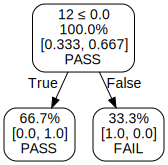

In [123]:
debugger = test_debugger_html(ClassifyingDebugger(CoverageCollector))
classifier = debugger.classifier()
debugger.show_classifier(classifier)

We can even use our classifier to predict the outcome of additional runs. If, for instance, we execute all lines except for, say, Line 7, 9, and 11, our tree classifier would predict failure – because the "culprit" line 12 is executed.

In [124]:
classifier.predict([[1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1]])

array([1])

Again, there are many ways to continue from here. Which events should we train the classifier from? How do classifiers compare in their performance and diagnostic quality? There are lots of possibilities left to explore, and we only begin to realize the potential for automated debugging.

We will encounter decision trees again in the [chapter on determining failure circumstances](Alhazen.ipynb).

## Synopsis

This chapter introduces classes and techniques for _statistical debugging_ – that is, correlating specific events, such as lines covered, with passing and failing outcomes.

To make use of the code in this chapter, use one of the provided `StatisticalDebugger` subclasses such as `TarantulaDebugger` or `OchiaiDebugger` instantiated with a `Collector` such as `CoverageCollector` denoting the type of events you want to correlate outcomes with. Here's a typical example:

In [125]:
debugger = TarantulaDebugger(CoverageCollector)
with debugger.collect_pass():
    remove_html_markup("abc")
with debugger.collect_pass():
    remove_html_markup('<b>abc</b>')
with debugger.collect_fail():
    remove_html_markup('"abc"')

You can then print out the observed events – in this case, line numbers – in a table, showing in which runs they occurred (`X`), and with colors highlighting the suspiciousness of the event. A "red" event means that the event predominantly occurs in failing runs.

In [126]:
debugger.event_table(args=True, color=True)

| `remove_html_markup` | `s='abc'` | `s='<b>abc</b>'` | `s='"abc"'` | 
| -- | ---- | ---- | ---- | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 1</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 2</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 3</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 4</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 6</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 7</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)"> 8</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)"> 9</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(120.0, 50.0%, 80%)">10</samp> |    - |    X |    - | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">11</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(0.0, 100.0%, 80%)">12</samp> |    - |    - |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">13</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">14</samp> |    X |    X |    X | 
| <samp style="background-color: hsl(60.0, 100.0%, 80%)">16</samp> |    X |    X |    X | 


If you collected coverage with `CoverageCollector`, you can also visualize the code with similar colors, highlighting suspicious lines:

In [127]:
debugger.list_with_spectrum()

The method `rank_by_suspiciousness()` returns a ranked list of events, starting with the most suspicious. This is useful for automated techniques that need potential defect locations.

In [128]:
debugger.rank_by_suspiciousness()

[12, 1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16, 8, 10]

Here are all classes defined in this chapter:

In [129]:
# ignore
from ClassDiagram import display_class_hierarchy

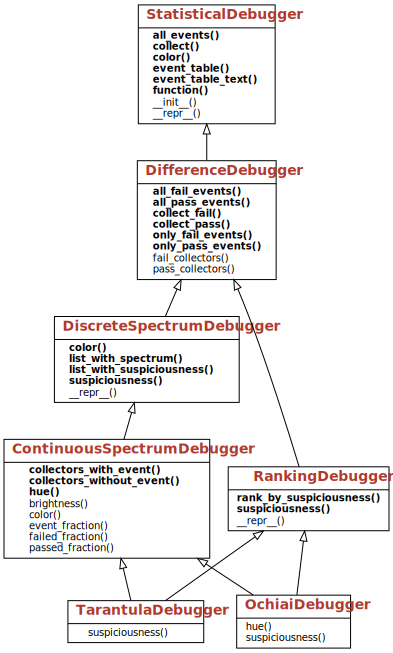

In [130]:
# ignore
display_class_hierarchy([TarantulaDebugger, OchiaiDebugger])

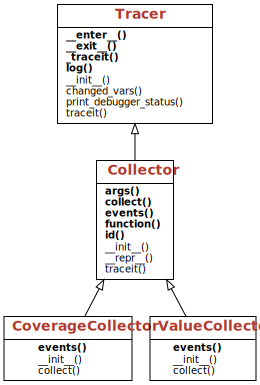

In [131]:
# ignore
display_class_hierarchy([CoverageCollector, ValueCollector])

## Lessons Learned

* _Correlations_ between execution events and outcomes (pass/fail) can make important hints for debugging
* Events occurring only (or mostly) during failing runs can be _highlighted_ and _ranked_ to guide the search
* Important hints include whether the _execution of specific code locations_ correlates with failure

## Next Steps

Chapters that build on this one include

* [how to determine invariants that correlate with failures](Invariants.ipynb)
* [how to train learners on input features](Alhazen.ipynb)
* [how to automatically repair programs](Repair.ipynb)

## Background

The seminal works on statistical debugging are the papers by Jones et al. \cite{Jones2002} on Tarantula as well as Liblit et al. \cite{Liblit2003} (who also introduced the term statistical debugging).

The Ochiai metric for fault localization was introduced by \cite{Abreu2009}. The overview by Wong et al. \cite{Wong2016} gives a comprehensive overview on the field of statistical fault localization.

The study by Parnin and Orso \cite{Parnin2011} is a must to understand the limitations of the technique.

## Exercises

To be added.